# Homework Assignment 2: Association Rules

## André Schweizer

### Import libraries and set parameters

In [84]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
pd.set_option('display.expand_frame_repr', False)
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['lines.markersize'] = 0.5

### Import data files

In [91]:
os.chdir('/Users/andreschweizer/Documents/2019W/IEMS 308/Association Rules/Dillards POS')
dept = pd.read_csv('deptinfo.csv')
skst = pd.read_csv('skstinfo.csv')
sku = pd.read_csv('skuinfo.csv')
store = pd.read_csv('strinfo.csv')
trnsct = pd.read_csv('trnsact.csv', header = None, names = ['SKU','STORE','REGISTER','TRANNUM','SEQ','SALEDATE','STYPE','QUANTITY','I','ORGPRICE','AMOUNT','INTERID','MIC','N'])

KeyboardInterrupt: 

### Clean data

In [ ]:
# Remove return transactions and unused columns in trnsct
trnsct = trnsct[trnsct.STYPE == 'P']
trnsct = trnsct.drop(['STYPE','N','I'], axis = 1)

In [ ]:
trnsct.head()

In [5]:
# Rearrange skst so SKU number is a column, not an index
skst = skst.reset_index()
skst.columns = ['SKU','STORE','COST','RETAIL','X']
skst = skst.drop('X', axis = 1)

In [6]:
skst.head()

,SKU,STORE,COST,RETAIL
0,3,102,123.36,440.0
1,3,103,123.36,440.0
2,3,104,123.36,440.0
3,3,202,123.36,440.0
4,3,203,123.36,440.0


### Select potential candidate SKUs

In [7]:
# Compute number of SKUs
len(sku.SKU)

1564178

In [8]:
# Only keep SKUs sold in IL
store = store.reset_index()
store.columns = ['STORE','CITY','STATE','ZIP','X']
store = store.drop(['X'],axis=1)
store = store[store.STATE == 'IL']
skst = skst[skst.STORE.isin(store.STORE)]

In [9]:
store

,STORE,CITY,STATE,ZIP
42,603,FAIRVIEW HEIGHTS,IL,62208
64,1003,MARION,IL,62959
251,4903,MOLINE,IL,61265


In [10]:
skst.head()

,SKU,STORE,COST,RETAIL
16,3,603,123.36,440.0
28,3,1003,123.36,440.0
153,3,4903,123.36,440.0
397,45,603,20.66,59.0
405,45,1003,20.66,59.0


In [11]:
### Select SKUs with significant contributions to aggregate profit margin
# Only keep SKUs for which there is profit data
trnsct = trnsct[(trnsct.SKU.isin(skst.SKU)) & (trnsct.STORE.isin(store.STORE))]
# Only keep profit data for SKUs that were sold in IL stores
skst = skst[skst.SKU.isin(trnsct.SKU)]
# Calculate unit profit margin for each SKU in each store
MARGIN = skst.RETAIL-skst.COST
skst = skst.join(pd.DataFrame(MARGIN))
skst.columns = ['SKU','STORE','COST','RETAIL','MARGIN']

# Group data by SKU and store
sku_groups = trnsct.groupby(by=['SKU','STORE'])

# Find how many of each SKU was sold at each store
quants = sku_groups.agg({'QUANTITY':['sum']})
quants = quants.reset_index()
quants.columns = ['SKU','STORE','QUANTITY']
PM = pd.merge(quants,skst,how='inner',on=['SKU','STORE'])

# Calculate the aggregate profit margin for each SKU
profit_margin = (PM.MARGIN)*PM.QUANTITY
PM = PM.join(pd.DataFrame(profit_margin))
PM.columns = ['SKU','STORE','QUANTITY','COST','RETAIL','MARGIN','PROFIT_MARGIN']
PM_grouped = PM.groupby(by = ['SKU'])
PM_aggregate = PM_grouped.agg({'PROFIT_MARGIN':['sum']})
PM_aggregate.columns = ['PROFIT_MARGIN']

In [12]:
# Remove SKUs with negative profit margins
pmf = PM_aggregate[PM_aggregate.PROFIT_MARGIN >= 0]

In [13]:
# Find SKUs that carry highest percentages of the profit margin
pmf = pmf.sort_values(by = ['PROFIT_MARGIN'], axis = 0, ascending = False)
pmf = pmf.reset_index()
cumul = pd.DataFrame(pmf.PROFIT_MARGIN.cumsum())
perc = pd.DataFrame((pmf.PROFIT_MARGIN.cumsum())/pmf.PROFIT_MARGIN.sum())
cumul.columns = ['CUMSUM']
perc.columns = ['PERCENTAGE']
pmf = pmf.join([cumul,perc])

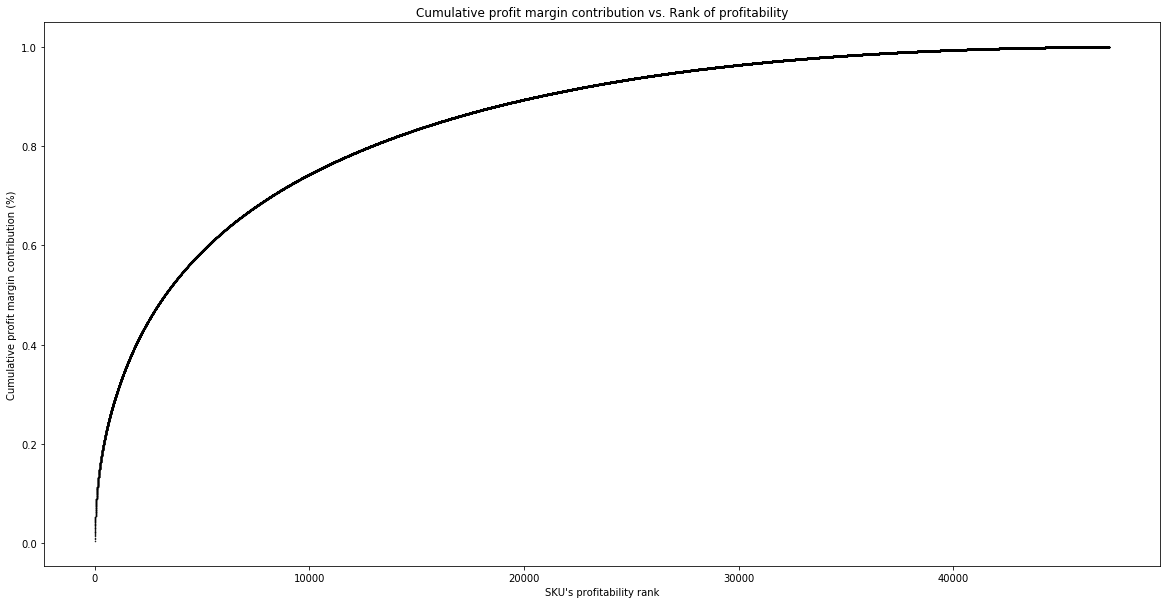

In [85]:
# Plot
plt.scatter(pmf.index,pmf.PERCENTAGE, c='black')
plt.title('Cumulative profit margin contribution vs. Rank of profitability')
plt.xlabel("SKU's profitability rank")
plt.ylabel("Cumulative profit margin contribution (%)")
plt.show()

In [15]:
# Find SKUs that represent 99% of profit margin
profitable_SKUs = pmf[pmf.PERCENTAGE < 0.99]

# Only keep transactions for SKUs that represent 99% of profit margin
trnsct = trnsct.loc[trnsct.SKU.isin(profitable_SKUs.SKU)]

In [16]:
### Select SKUs with relevant popularity
# Find basket sizes
trnsct['BASKET'] = trnsct.STORE.astype(str)+trnsct.TRANNUM.astype(str)+trnsct.SALEDATE.astype(str)
basket_groups = trnsct.groupby(by=['BASKET'])
basketssizes = basket_groups.agg({'SKU':['count']})
basketssizes.columns = ['SKUs']
avgbasketsize = basketssizes.SKUs.mean()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
basketssizes.head()

,SKUs
BASKET,
1003100002004-08-24,1
1003100002004-10-02,2
1003100002004-10-05,1
1003100002004-10-06,3
1003100002004-10-07,2


In [18]:
avgbasketsize

4.604260331795426

In [87]:
# Find number of baskets each SKU is present in
sku_baskets = trnsct.groupby(by=['SKU'])
basketcounts = sku_baskets.agg({'BASKET':['count']})
basketcounts.columns= ['BASKETS']
basketcounts = basketcounts.sort_values(by = ['BASKETS'], axis = 0, ascending = False)

In [90]:
basketcounts.shape

(2000, 1)

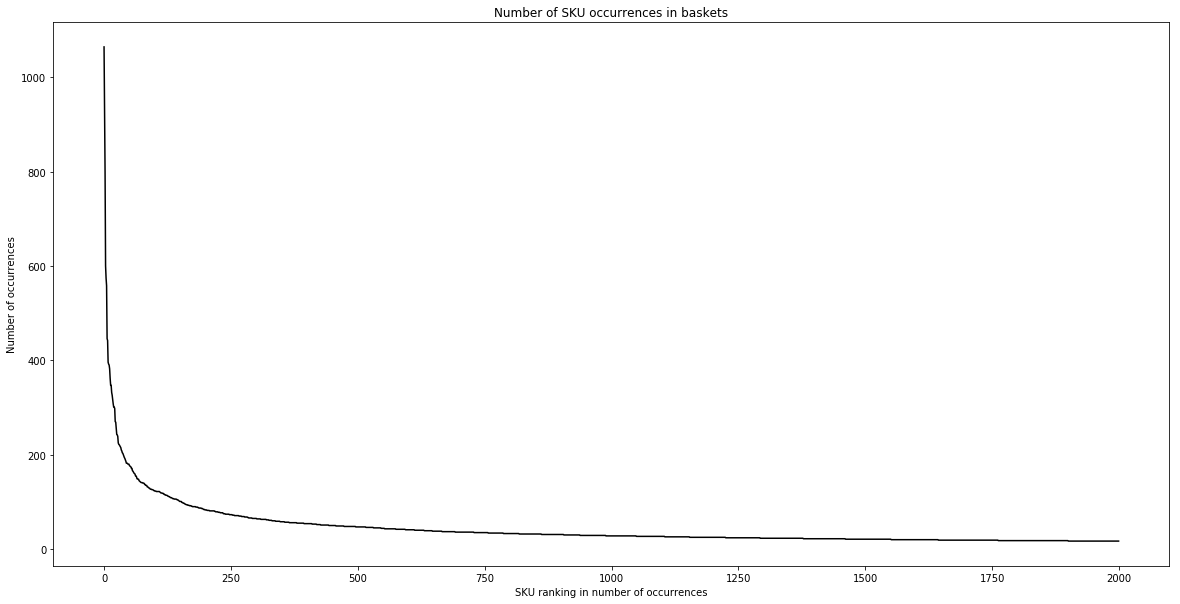

In [86]:
# Plot
plt.plot(basketcounts.reset_index().index,basketcounts.BASKETS, c = 'black')
plt.title("Number of SKU occurrences in baskets")
plt.xlabel("SKU ranking in number of occurrences")
plt.ylabel("Number of occurrences")
plt.show()

In [22]:
# Only keep 2000 most popular SKUs and their corresponding transactions
basketcounts = basketcounts.iloc[0:2000,:]
trnsct = trnsct[trnsct.SKU.isin(basketcounts.index)]
sku = sku[sku.SKU.isin(basketcounts.index)]

In [23]:
basketcounts.head()

,BASKETS
SKU,
3524026,1064
3978011,934
5528349,799
803921,600
3161221,574


### Association rules

In [25]:
# One-hot encode transactions
basket_skus = trnsct[['BASKET','SKU']]
baskets = pd.crosstab(basket_skus.BASKET,basket_skus.SKU, margins=True)
baskets.to_csv("baskets")
baskets = baskets.drop(['All'], axis = 1)
baskets = baskets.drop(['All'], axis = 0)
baskets[baskets > 1] = 1
baskets = baskets.astype('bool')

In [26]:
baskets.head()

SKU,7915,9633,9951,10896,17915,19171,19633,19951,27402,28371,...,9957390,9964307,9969756,9978362,9979950,9982306,9992306,9993749,9999170,9999950
BASKET,,,,,,,,,,,,,,,,,,,,,
1003100002004-10-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1003100002004-10-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1003100002004-10-07,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1003100002004-10-08,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1003100002004-10-09,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
# Use apriori to find association rules
support = apriori(baskets,min_support = 0.0001, use_colnames = True)

In [59]:
support.head()

,support,itemsets
0,0.002300,(7915)
1,0.002091,(9633)
2,0.000687,(9951)
3,0.001464,(10896)
4,0.001703,(17915)


In [60]:
# Mine association rules based on support values
rules_sup = association_rules(support, metric="support", min_threshold = 0.001)
rules_sup = rules_sup.sort_values(by = ['support'], axis = 0, ascending = False)
rules_sup.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,(3898011),(3968011),0.010544,0.012814,0.003256,0.308782,24.096502,0.003121,1.428182
34,(3968011),(3898011),0.012814,0.010544,0.003256,0.254079,24.096502,0.003121,1.326489
33,(3978011),(3524026),0.027302,0.030587,0.003196,0.117068,3.827341,0.002361,1.097947
32,(3524026),(3978011),0.030587,0.027302,0.003196,0.104492,3.827341,0.002361,1.086198
14,(3978011),(3898011),0.027302,0.010544,0.002599,0.095186,9.027300,0.002311,1.093546


In [61]:
# Mine association rules based on confidence values
rules_conf = association_rules(support, metric="confidence", min_threshold=0.001)
rules_conf = rules_conf.sort_values(by = ['confidence'], axis = 0, ascending = False)
rules_conf.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3176,(3218302),(2088302),0.000209,0.000329,0.000209,1.0,3043.454545,0.000209,inf
4346,"(6290353, 6370353)",(6260353),0.000119,0.000926,0.000119,1.0,1079.935484,0.000119,inf
1930,(4472217),(7351914),0.000597,0.003435,0.000597,1.0,291.113043,0.000595,inf
572,(6833806),(7063806),0.000329,0.000448,0.000329,1.0,2231.866667,0.000328,inf
3004,"(3547981, 2754854)",(3537981),0.000149,0.012994,0.000149,1.0,76.960920,0.000147,inf


In [62]:
# Rank rules by confidence, support and lift
rules_conf["Rank Sup"] = rules_conf["support"].rank(method = 'min', ascending = False)
rules_conf["Rank Conf"] = rules_conf["confidence"].rank(method = 'min', ascending = False)
rules_conf["Rank Lift"] = rules_conf["lift"].rank(method = 'min', ascending = False)
rules_sup["Rank Sup"] = rules_sup["support"].rank(method = 'min', ascending = False)
rules_sup["Rank Conf"] = rules_sup["confidence"].rank(method = 'min', ascending = False)
rules_sup["Rank Lift"] = rules_sup["lift"].rank(method = 'min', ascending = False)

In [63]:
rules_sup.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Rank Sup,Rank Conf,Rank Lift
35,(3898011),(3968011),0.010544,0.012814,0.003256,0.308782,24.096502,0.003121,1.428182,1.0,7.0,15.0
34,(3968011),(3898011),0.012814,0.010544,0.003256,0.254079,24.096502,0.003121,1.326489,1.0,11.0,15.0
33,(3978011),(3524026),0.027302,0.030587,0.003196,0.117068,3.827341,0.002361,1.097947,3.0,26.0,31.0
32,(3524026),(3978011),0.030587,0.027302,0.003196,0.104492,3.827341,0.002361,1.086198,3.0,27.0,32.0
14,(3978011),(3898011),0.027302,0.010544,0.002599,0.095186,9.027300,0.002311,1.093546,5.0,28.0,25.0


In [64]:
rules_conf.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Rank Sup,Rank Conf,Rank Lift
3176,(3218302),(2088302),0.000209,0.000329,0.000209,1.0,3043.454545,0.000209,inf,1077.0,1.0,5.0
4346,"(6290353, 6370353)",(6260353),0.000119,0.000926,0.000119,1.0,1079.935484,0.000119,inf,2833.0,1.0,299.0
1930,(4472217),(7351914),0.000597,0.003435,0.000597,1.0,291.113043,0.000595,inf,85.0,1.0,1117.0
572,(6833806),(7063806),0.000329,0.000448,0.000329,1.0,2231.866667,0.000328,inf,391.0,1.0,23.0
3004,"(3547981, 2754854)",(3537981),0.000149,0.012994,0.000149,1.0,76.960920,0.000147,inf,1895.0,1.0,1581.0


In [65]:
#%% Compute average rank between 3 metrics
rules_conf["Avg Rank"] = rules_conf.loc[:,["Rank Sup","Rank Conf", "Rank Lift"]].mean(axis = 1)
rules_sup["Avg Rank"] = rules_sup.loc[:,["Rank Sup","Rank Conf", "Rank Lift"]].mean(axis = 1)
rules_conf = rules_conf.sort_values(by = ["Avg Rank"], axis = 0)
rules_sup = rules_sup.sort_values(by = ["Avg Rank"], axis = 0)

In [66]:
rules_sup.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Rank Sup,Rank Conf,Rank Lift,Avg Rank
22,"(3898011, 3690654)",(3968011),0.001882,0.012814,0.001703,0.904762,70.605173,0.001678,10.365449,13.0,1.0,1.0,5.000000
21,"(3968011, 3690654)",(3898011),0.002390,0.010544,0.001703,0.712500,67.572450,0.001677,3.441585,13.0,2.0,3.0,6.000000
35,(3898011),(3968011),0.010544,0.012814,0.003256,0.308782,24.096502,0.003121,1.428182,1.0,7.0,15.0,7.666667
20,"(3968011, 3898011)",(3690654),0.003256,0.011291,0.001703,0.522936,46.314402,0.001666,2.072486,13.0,5.0,7.0,8.333333
34,(3968011),(3898011),0.012814,0.010544,0.003256,0.254079,24.096502,0.003121,1.326489,1.0,11.0,15.0,9.000000


In [67]:
rules_conf.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Rank Sup,Rank Conf,Rank Lift,Avg Rank
1287,(2657335),(2637335),0.000388,0.000508,0.000388,1.000000,1969.294118,0.000388,inf,243.0,1.0,45.0,96.333333
1804,"(4752472, 4722472)",(4772472),0.000358,0.000597,0.000358,1.000000,1673.900000,0.000358,inf,291.0,1.0,93.0,128.333333
2694,(2327335),(2397335),0.000388,0.000508,0.000358,0.923077,1817.809955,0.000358,12.993399,291.0,40.0,69.0,133.333333
1286,(2637335),(2657335),0.000508,0.000388,0.000388,0.764706,1969.294118,0.000388,4.248350,243.0,124.0,45.0,137.333333
572,(6833806),(7063806),0.000329,0.000448,0.000329,1.000000,2231.866667,0.000328,inf,391.0,1.0,23.0,138.333333


### Extract candidate SKUs from rules

In [68]:
# Convert frozen sets into lists
rules_conf.antecedents = map(list,rules_conf.antecedents)
rules_conf.consequents = map(list,rules_conf.consequents)
rules_sup.antecedents = map(list,rules_sup.antecedents)
rules_sup.consequents = map(list,rules_sup.consequents)

In [69]:
# Take SKUs in the strongest rules by support
skus_sup_ant = pd.Series(sum(rules_sup.antecedents,[]))
skus_sup_con = pd.Series(sum(rules_sup.consequents,[]))
skus_sup_ant = list(set(skus_sup_ant))
skus_sup_con = list(set(skus_sup_con))
skus_sup = np.array(list(set(skus_sup_ant + skus_sup_con)))

In [70]:
# Take SKUs in 1000 strongest rules by confidence
skus_conf_ant = pd.Series(sum(rules_conf.antecedents.head(1000),[]))
skus_conf_con = pd.Series(sum(rules_conf.consequents.head(1000),[]))
skus_conf_ant = list(set(skus_conf_ant))
skus_conf_con = list(set(skus_conf_con))
skus_conf = np.array(list(set(skus_conf_ant + skus_conf_con)))

In [71]:
### Match SKUs to their names and departments

# 10/12 SKUs in rules by support are in the strongest rules by confidence, so just use rules by confidece
skus1 = pd.Series(skus_sup).isin(pd.Series(skus_conf))

# Only take 100 SKUs in the strongest rules
skus_conf = pd.Series(skus_conf).iloc[0:100]
finalskus = sku[sku.SKU.isin(skus_conf)]

In [106]:
finalskus.head()
finalskus.to_csv("finalskus")

### Extra code used for analysis

In [79]:
# Number of SKUs with negative profit margins
skst[skst.MARGIN < 0].shape

(51983, 5)

In [82]:
# Number of SKUs with significant contribution to profit margin
pmf[pmf.PERCENTAGE < 0.99].shape

(37753, 4)

In [95]:
# Individual support summary
print(support.support.mean())
print(support.support.min())
print(support.support.max())
print(support.support.std())
print(support.support.median())

0.000700132895162
0.00011948145050480913
0.030587251329231138
0.00132930105791
0.000388314714141


In [98]:
# Rules support summary
print(rules_sup.support.mean())
print(rules_sup.support.min())
print(rules_sup.support.max())
print(rules_sup.support.std())
print(rules_sup.support.median())

print(rules_conf.support.mean())
print(rules_conf.support.min())
print(rules_conf.support.max())
print(rules_conf.support.std())
print(rules_conf.support.median())

0.00179388122216
0.0010155923292908776
0.003255869526256049
0.000662669975087
0.00162793476313
0.000202558809042
0.00011948145050480913
0.003255869526256049
0.000186137427545
0.000149351813131


In [100]:
# Rules confidence summary
print(rules_sup.confidence.mean())
print(rules_sup.confidence.min())
print(rules_sup.confidence.max())
print(rules_sup.confidence.std())
print(rules_sup.confidence.median())

print(rules_conf.confidence.mean())
print(rules_conf.confidence.min())
print(rules_conf.confidence.max())
print(rules_conf.confidence.std())
print(rules_conf.confidence.median())

0.231317220746
0.033203125
0.9047619047619047
0.205665653256
0.1594250685
0.166537504679
0.00390625
1.0
0.217898803429
0.0584415584416


In [107]:
# Rules lift summary
print(rules_sup.lift.mean())
print(rules_sup.lift.min())
print(rules_sup.lift.max())
print(rules_sup.lift.std())
print(rules_sup.lift.median())

print(rules_conf.lift.mean())
print(rules_conf.lift.min())
print(rules_conf.lift.max())
print(rules_conf.lift.std())
print(rules_conf.lift.median())

26.0910370862
1.9433115712412588
70.6051726051726
22.8081732286
17.0888798132
233.203391547
0.43736935618729095
3487.291666666666
440.714051304
11.3240032134


In [109]:
# Number of departments final SKUs are in
finalskus.DEPT.nunique()

13

In [111]:
# Number of original departments
dept.index.nunique()

60

In [115]:
# Number of total brands
sku.BRAND.nunique()

1960

In [116]:
# Number of brands in final SKUs
finalskus.BRAND.nunique()

26

In [119]:
# Departments final SKUs are in
finaldept = dept[dept.index.isin(finalskus.DEPT)]
finaldept

,DEPT,DEPTDESC
800,CLINIQUE,0
1202,CABERN,0
1301,BE2,0
2105,R TAYLOR,0
2107,MAI,0
2200,CELEBRT,0
2301,BEP,0
4505,POLOMEN,0
5207,H SIERR,0
6107,NOB,0
